In [1]:
from datasets import load_dataset

train_ds = load_dataset("imagefolder", data_dir="audio_transformer/data/train", split="train")


# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


print(len(train_ds),len(test_ds),len(val_ds))

Resolving data files:   0%|          | 0/8733 [00:00<?, ?it/s]

Using custom data configuration default-056bb73702904399
Reusing dataset image_folder (/home/ubuntu/.cache/huggingface/datasets/image_folder/default-056bb73702904399/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


5500 2620 612


In [2]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 5500
})

In [3]:
import json

with open('audio_transformer/data/label2id.json') as f:
    label2id = json.load(f)

with open('audio_transformer/data/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [4]:

from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [5]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [6]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [7]:
train_ds[:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7FB1F036CDD8>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7FB1F036C4E0>],
 'classID': [4, 6],
 'class': ['drilling', 'gun_shot'],
 'pixel_values': [tensor([[[ 0.3961,  0.3725,  0.2941,  ...,  0.5686,  0.5686,  0.5686],
           [ 0.3961,  0.3804,  0.3255,  ...,  0.6078,  0.6078,  0.6157],
           [ 0.3961,  0.3882,  0.3569,  ...,  0.6471,  0.6549,  0.6706],
           ...,
           [ 0.2314,  0.2471,  0.3020,  ...,  0.4275,  0.5373,  0.7804],
           [ 0.2157,  0.2314,  0.2941,  ...,  0.4118,  0.5294,  0.7804],
           [ 0.4980,  0.5216,  0.5843,  ...,  0.5216,  0.6235,  0.8039]],
  
          [[-0.5843, -0.5922, -0.6157,  ..., -0.5137, -0.5137, -0.5137],
           [-0.5843, -0.5922, -0.6078,  ..., -0.4980, -0.4980, -0.4902],
           [-0.5843, -0.5843, -0.5922,  ..., -0.4824, -0.4745, -0.4667],
           ...,
           [-0.6314, -0.6235, -0.6157,  ..., -0.5686, -0.

In [8]:

from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [9]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [10]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import file_utils
print(file_utils.default_cache_path)

/home/ubuntu/.cache/huggingface/transformers


In [13]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [14]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [16]:

# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

In [17]:
trainer.train()

/home/ubuntu/anaconda3/envs/aws_neuron_pytorch_p36/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5500
  Num Epochs = 5
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2750


Epoch,Training Loss,Validation Loss,Accuracy
1,1.432900,0.860617,0.821895
2,0.882300,0.646744,0.851307
3,0.716800,0.469054,0.900327
4,0.612300,0.409169,0.893791
5,0.534200,0.361285,0.923203


***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-550
Configuration saved in test-cifar-10/checkpoint-550/config.json
Model weights saved in test-cifar-10/checkpoint-550/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-550/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1100
Configuration saved in test-cifar-10/checkpoint-1100/config.json
Model weights saved in test-cifar-10/checkpoint-1100/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-1100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 612
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-1650
Configuration saved in test-cifar-10/checkpoint-1650/config.json
Model weights saved in test-cifar-10/checkpoint-1650/pytorch_model.bin
Feature extractor saved in test-cifar-10/checkpoint-16

TrainOutput(global_step=2750, training_loss=0.8052671314586293, metrics={'train_runtime': 4492.7794, 'train_samples_per_second': 6.121, 'train_steps_per_second': 0.612, 'total_flos': 2.13118251236352e+18, 'train_loss': 0.8052671314586293, 'epoch': 5.0})

In [18]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 2620
  Batch size = 4


In [19]:
print(outputs.metrics)

{'test_loss': 0.41575756669044495, 'test_accuracy': 0.9030534351145039, 'test_runtime': 139.2693, 'test_samples_per_second': 18.812, 'test_steps_per_second': 4.703}


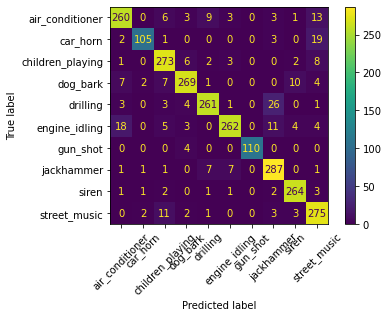

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = id2label.values()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7FB1AFF3F3C8>,
 'classID': 7,
 'class': 'jackhammer',
 'pixel_values': tensor([[[-0.8039, -0.8745, -0.8980,  ..., -0.9216, -0.9137, -0.9294],
          [-0.6941, -0.7647, -0.7882,  ..., -0.8039, -0.7961, -0.7882],
          [-0.2784, -0.3490, -0.3725,  ..., -0.3882, -0.3490, -0.2863],
          ...,
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9765,  0.9765,  0.9765],
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9765,  0.9765,  0.9765],
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9922,  0.9922,  0.9922]],
 
         [[-0.8824, -0.9059, -0.9216,  ..., -0.9373, -0.9294, -0.9451],
          [-0.8667, -0.8980, -0.9059,  ..., -0.9216, -0.9137, -0.9216],
          [-0.8196, -0.8510, -0.8588,  ..., -0.8588, -0.8431, -0.8196],
          ...,
          [ 0.6471,  0.5373,  0.4980,  ...,  0.8431,  0.8745,  0.9216],
          [ 0.5922,  0.5137,  0.4824,  ...,  0.8039,  0.8275,  0.8353],
          [ 0.3647,  0.3725,

In [23]:
output2 = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 4
  Batch size = 4


KeyError: 0

In [24]:
test_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7FB0EC50B8D0>,
 'classID': 7,
 'class': 'jackhammer',
 'pixel_values': tensor([[[-0.8039, -0.8745, -0.8980,  ..., -0.9216, -0.9137, -0.9294],
          [-0.6941, -0.7647, -0.7882,  ..., -0.8039, -0.7961, -0.7882],
          [-0.2784, -0.3490, -0.3725,  ..., -0.3882, -0.3490, -0.2863],
          ...,
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9765,  0.9765,  0.9765],
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9765,  0.9765,  0.9765],
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9922,  0.9922,  0.9922]],
 
         [[-0.8824, -0.9059, -0.9216,  ..., -0.9373, -0.9294, -0.9451],
          [-0.8667, -0.8980, -0.9059,  ..., -0.9216, -0.9137, -0.9216],
          [-0.8196, -0.8510, -0.8588,  ..., -0.8588, -0.8431, -0.8196],
          ...,
          [ 0.6471,  0.5373,  0.4980,  ...,  0.8431,  0.8745,  0.9216],
          [ 0.5922,  0.5137,  0.4824,  ...,  0.8039,  0.8275,  0.8353],
          [ 0.3647,  0.3725,

In [25]:
model.save_pretrained("/home/ubuntu/models/AudioViT")

Configuration saved in /home/ubuntu/models/AudioViT/config.json
Model weights saved in /home/ubuntu/models/AudioViT/pytorch_model.bin
